# Draw phylogenies of Ireland and global M. bovis samples

<div class="alert alert-block alert-info"><b>R Script to draw trees</b> </div>

In [2]:
setwd('/home/farrell/gitprojects/snipgenie/notebooks')
source('drawtrees.R')

In [3]:
options(repr.plot.width=22, repr.plot.height=15)

In [4]:
gltree <- read.tree('/storage/btbgenie/global_results/tree.newick')
glmeta <- read.table('/storage/btbgenie/global_results/metadata.csv',sep=',',
                      header=TRUE,row.names=1)
glmeta[] <- lapply(glmeta, as.character)

iremeta <- read.table('/storage/btbgenie/all_ireland_results/metadata.csv',sep=',',
                      header=TRUE,row.names=1)
iremeta[] <- lapply(iremeta, as.character)
print (length(rownames(iremeta)))
iretree <- read.tree('/storage/btbgenie/all_ireland_results/tree.newick')

cmeta <- read.table('/storage/btbgenie/combined_results/metadata.csv',sep=',',header=TRUE,row.names=2)
cmeta[] <- lapply(cmeta, as.character)
#cmeta[is.na(cmeta)] <- "-"
#cmeta[] <- lapply(meta, as.character)
combtree <- read.tree('/storage/btbgenie/combined_results/tree.newick')

[1] 1435


## global

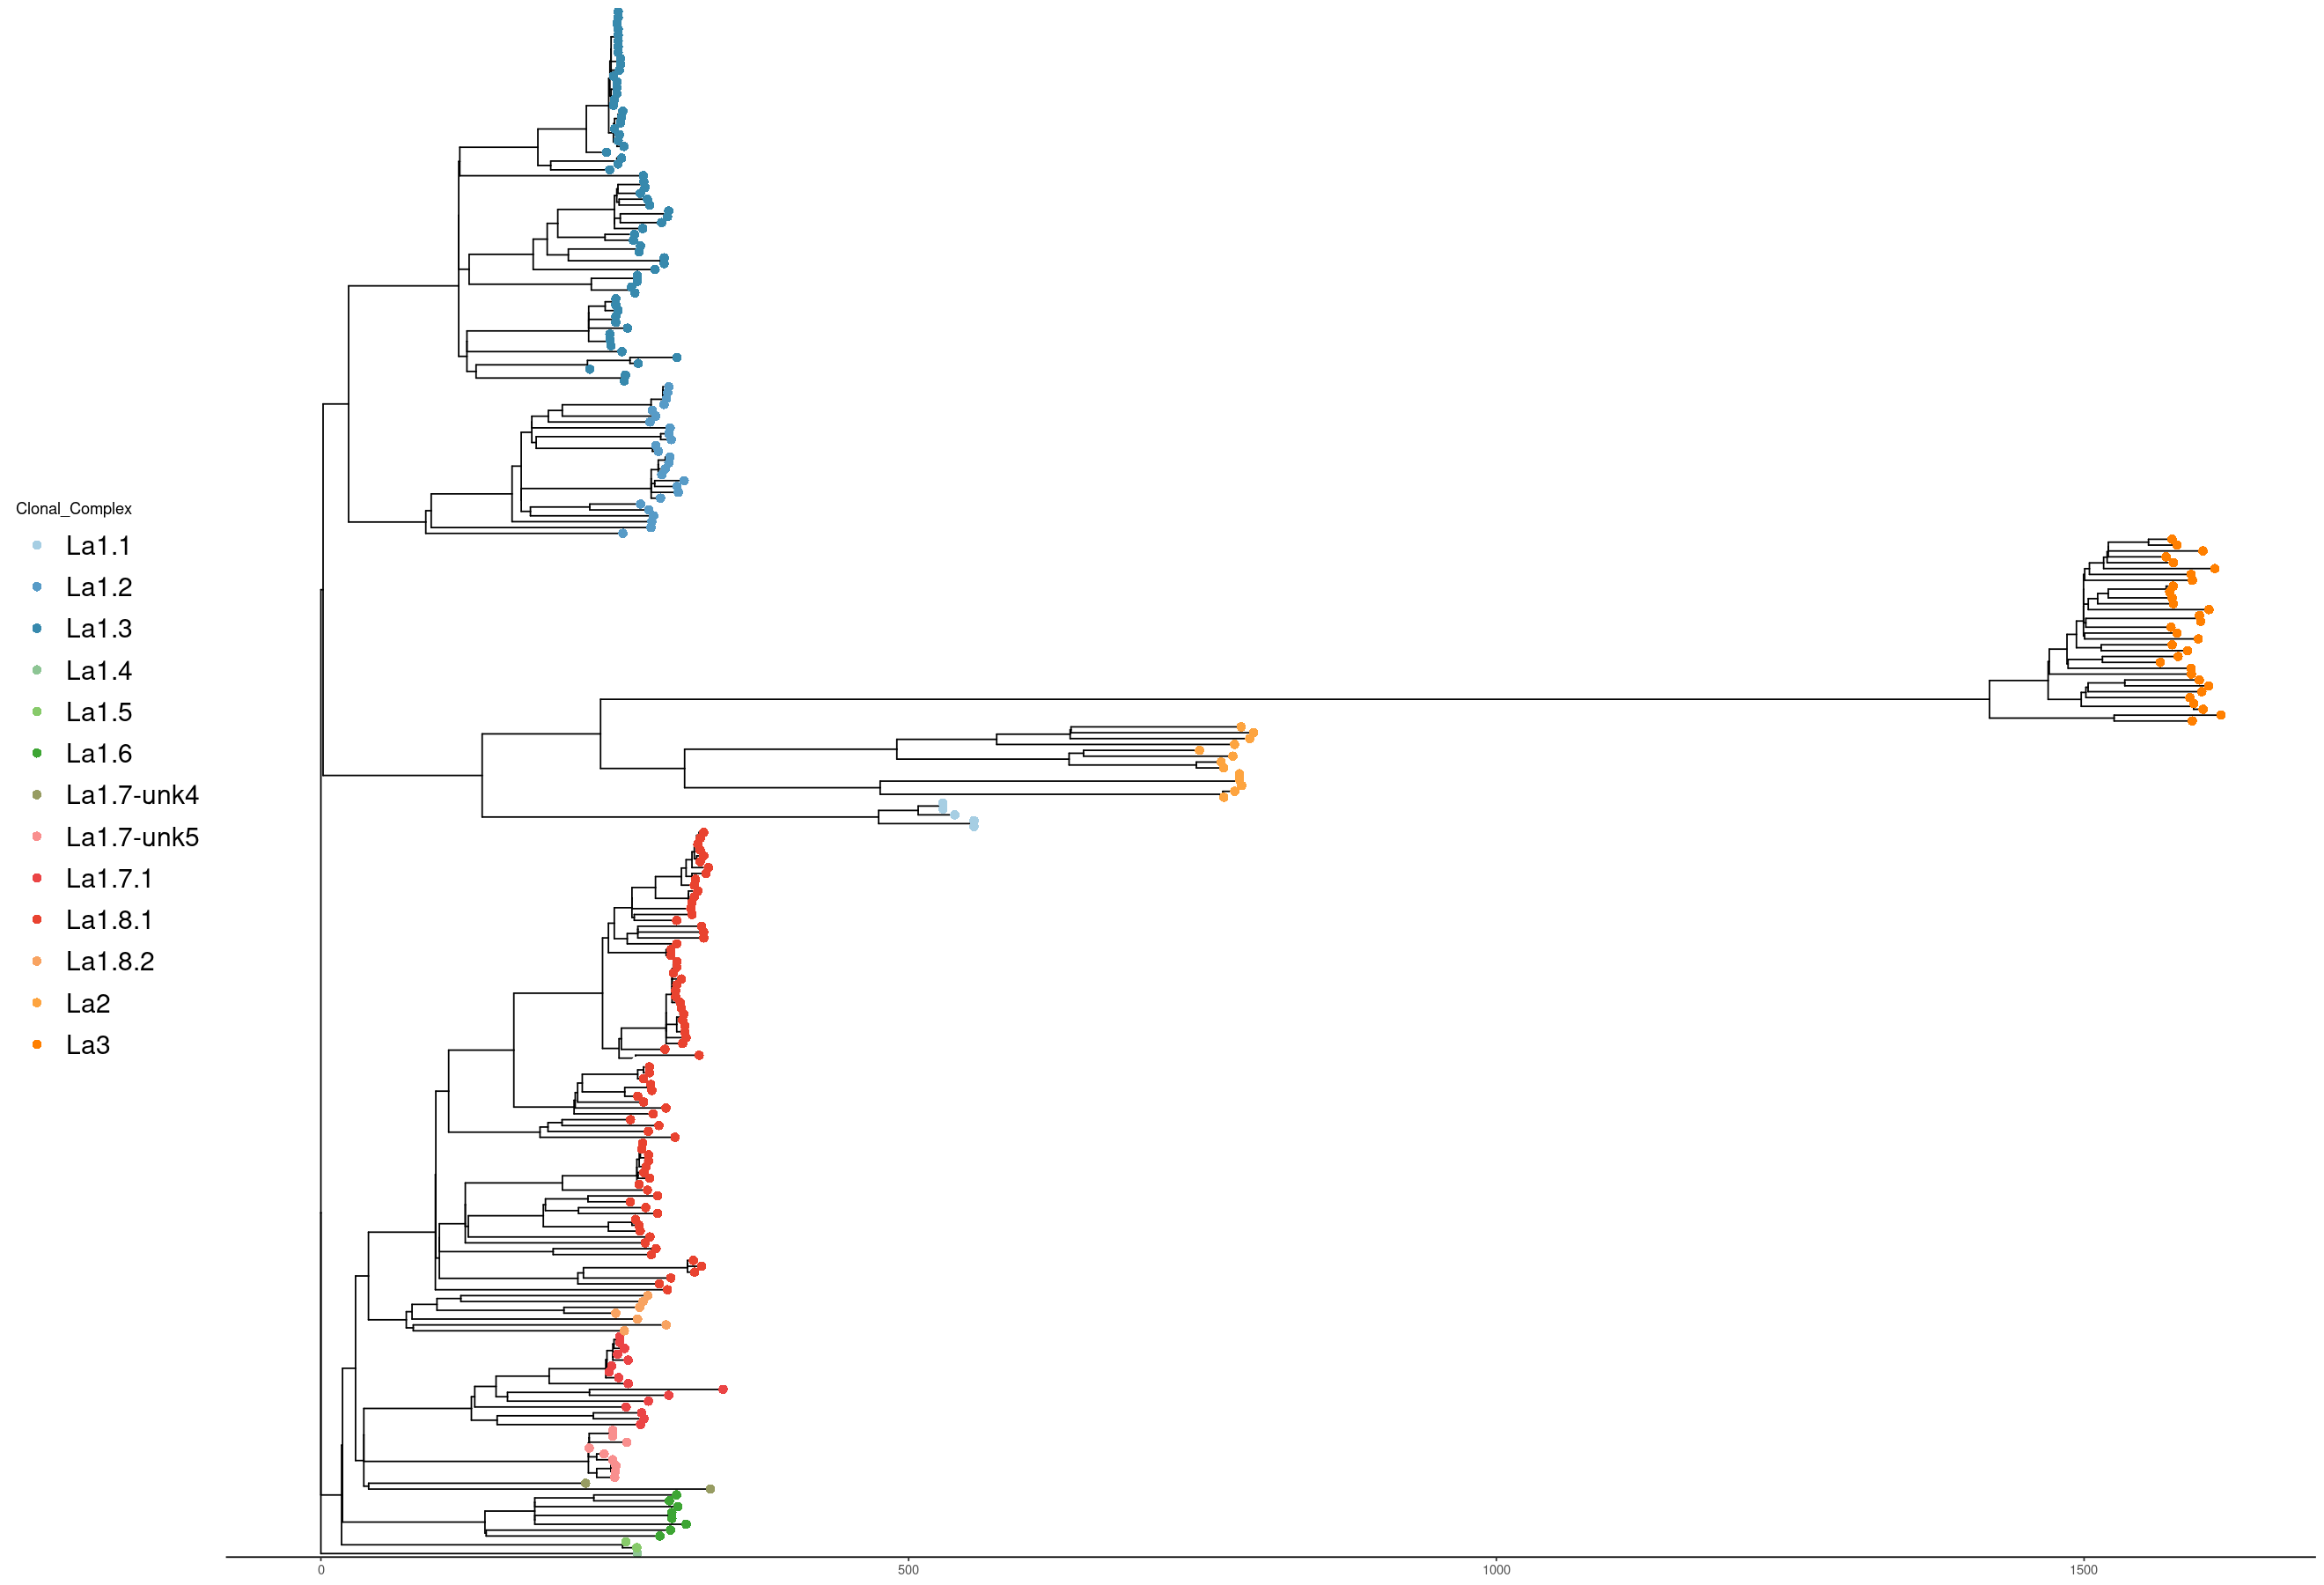

In [6]:
tips<-row.names(glmeta[glmeta$Clonal_Complex %in% c('La3','La2'),])
stree <- drop.tip(gltree, tips)
ggplottree(gltree, glmeta, layout='rect', cols=c('Clonal_Complex'), cmaps=c('Paired'))

## combined, global + Ireland

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


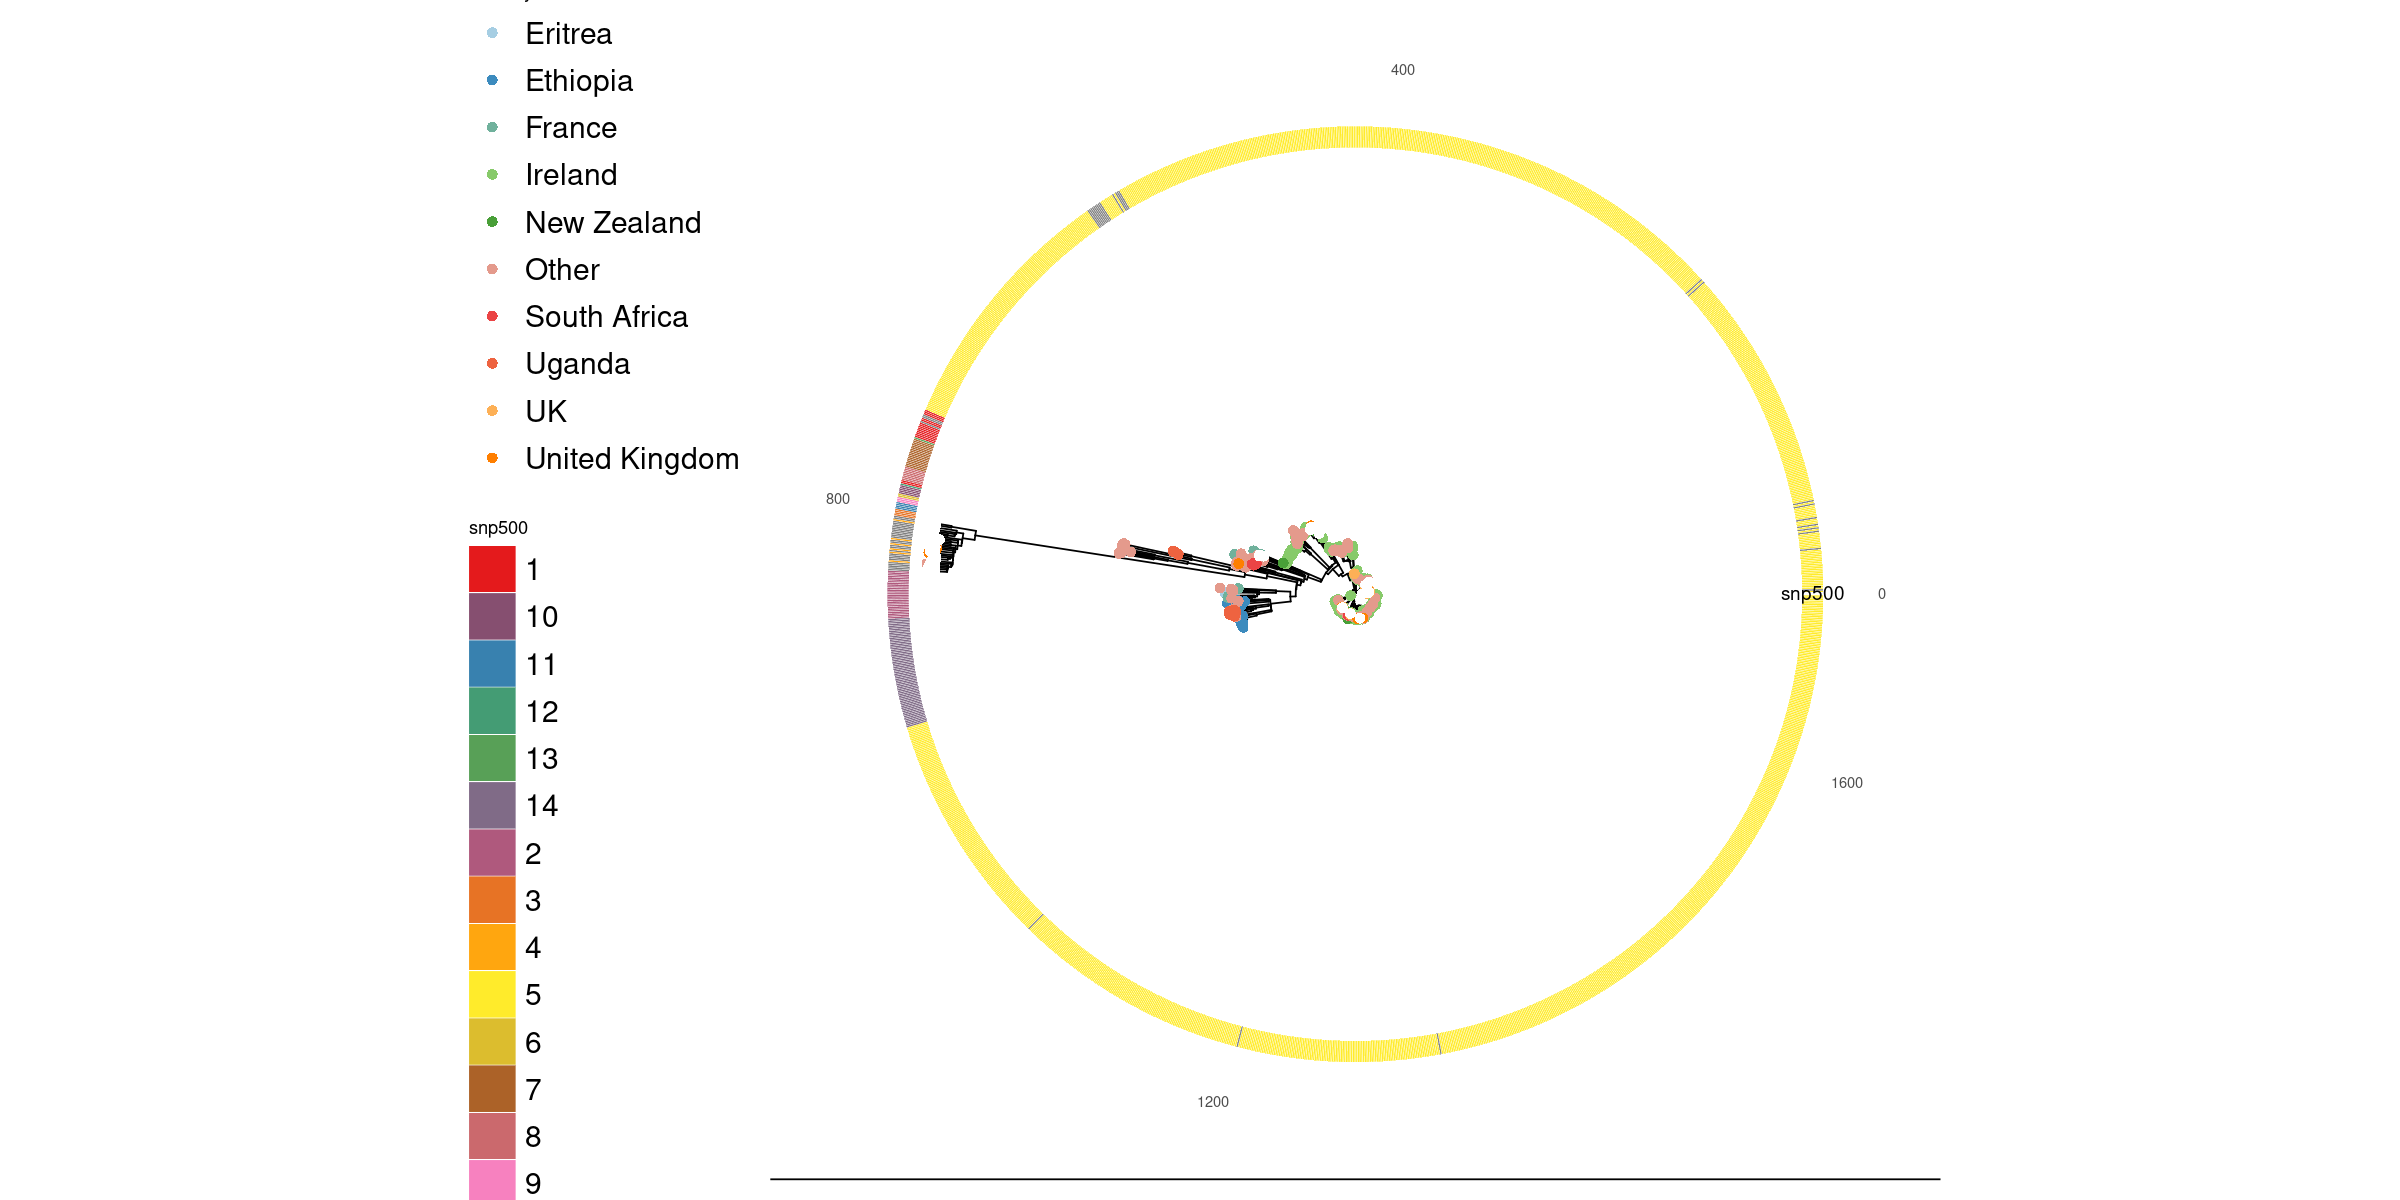

In [9]:
#tree<-root(combtree,'ERR2513607')
ggplottree(combtree, cmeta, layout='c', cols=c('Country1','snp500'), cmaps=c('Paired','Set1'))

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


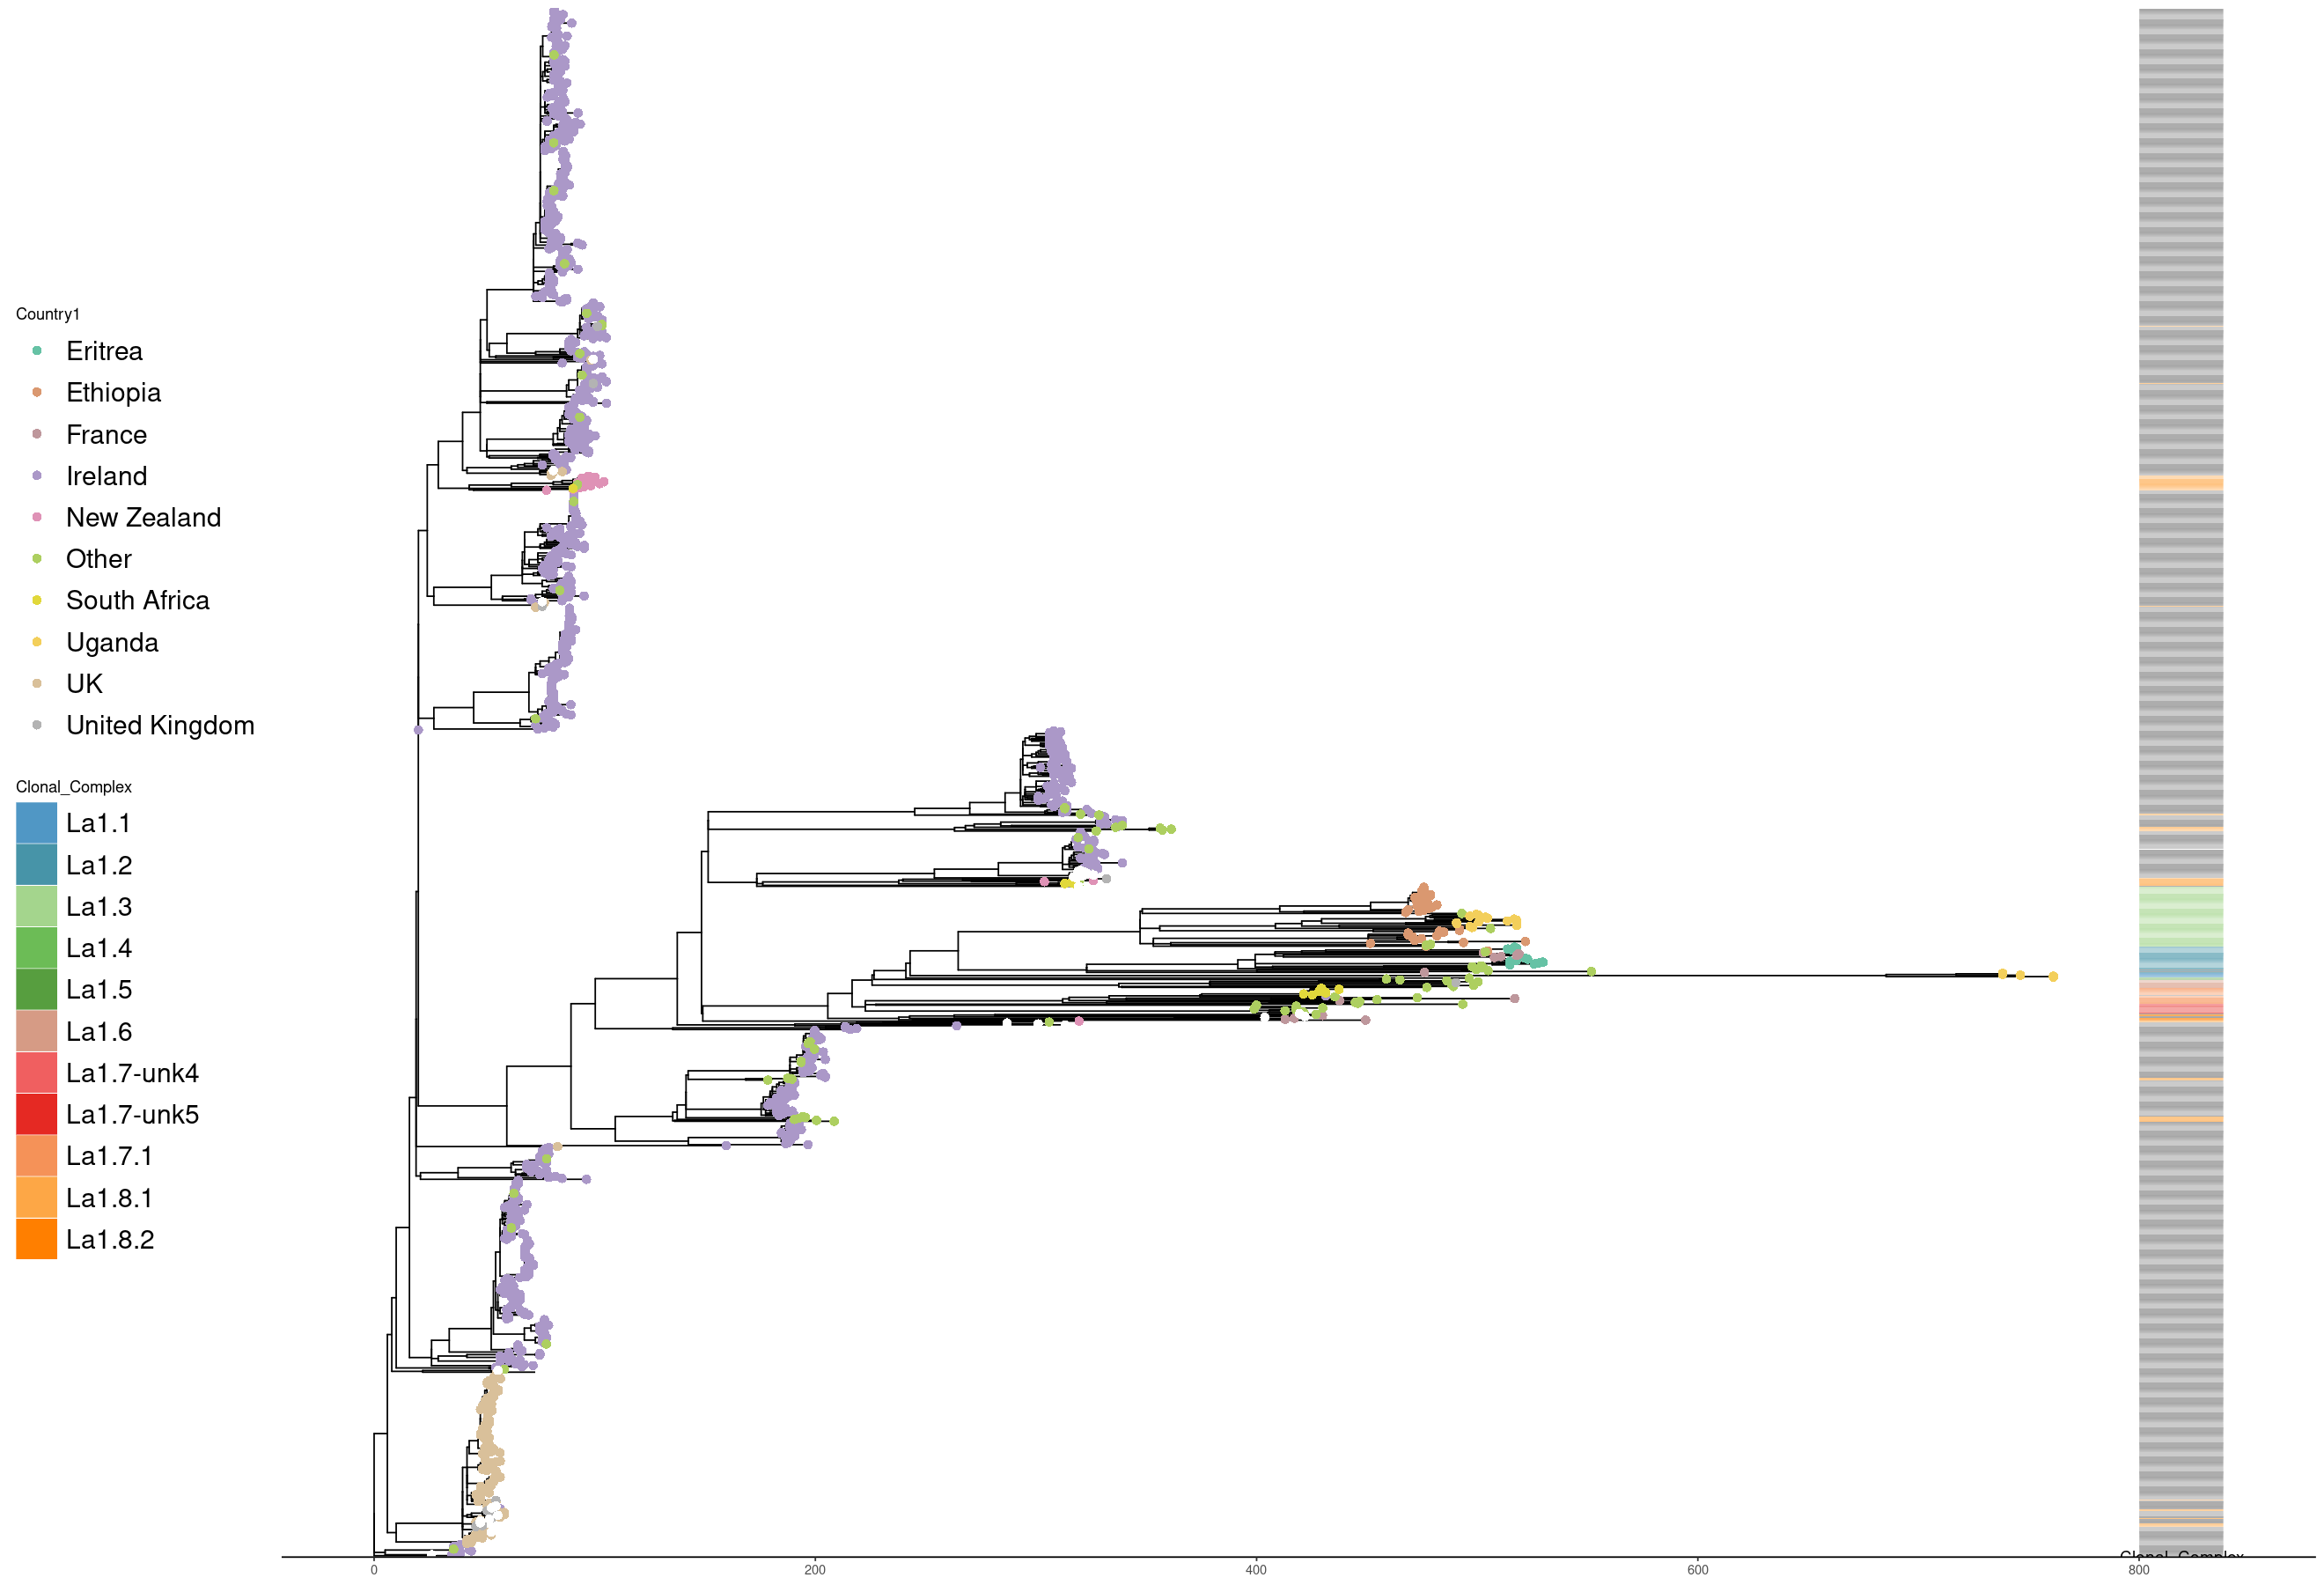

In [49]:
#randtips<-sample(combtree$tip.label,70)
#randtree <- keep.tip(combtree, randtips)
tips<-row.names(glmeta[glmeta$Clonal_Complex %in% c('La3','La2'),])
stree<-drop.tip(combtree,tips)
ggplottree(stree, cmeta, layout='rect', cols=c('Country1','Clonal_Complex'), cmaps=c('Set2','Paired'))

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


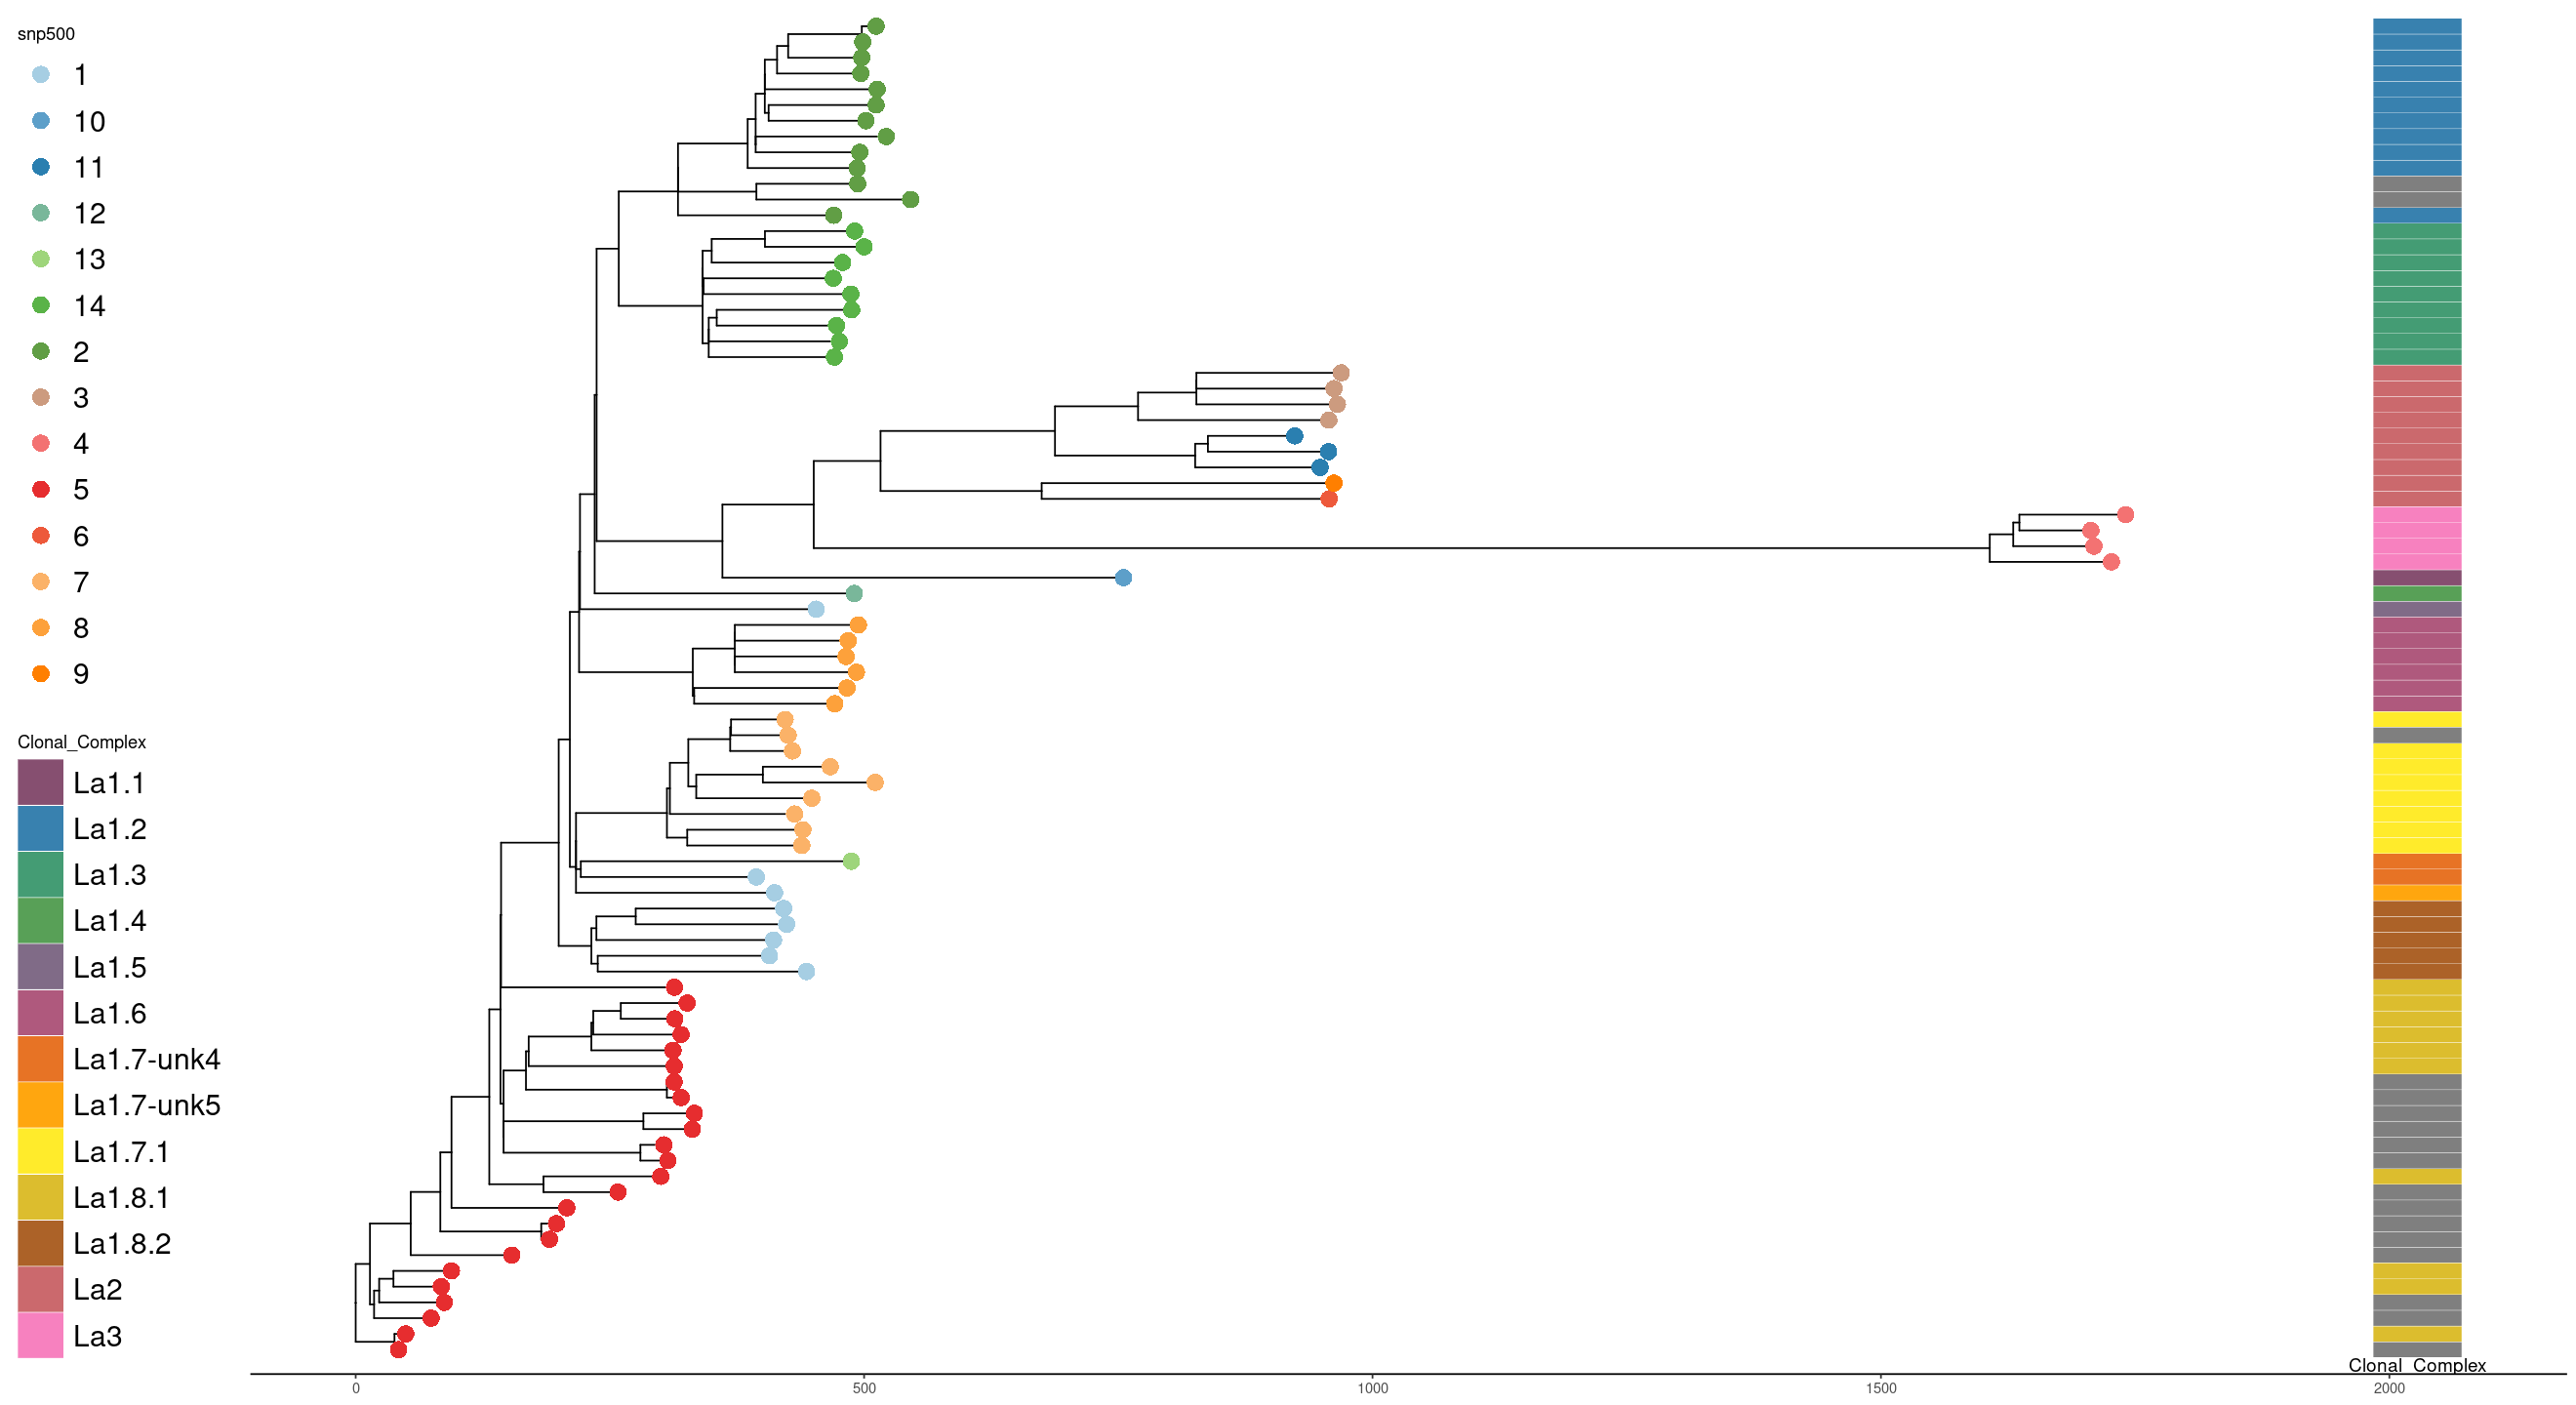

In [18]:
options(repr.plot.width=22, repr.plot.height=12)
uniq <- row.names(distinct(cmeta,snp200,Country1,.keep_all = TRUE))
stree <- keep.tip(combtree, uniq)
ggplottree(stree, cmeta, layout='rect', cols=c('snp500','Clonal_Complex'), cmaps=c('Paired','Set1'), tipsize=5, offset=100)

In [50]:
p1<-ggplottree(stree, cmeta, layout='unrooted', cols=c('snp500'), cmaps=c('Set1'), tipsize=5)
p2<-ggplottree(stree, cmeta, layout='unrooted', cols=c('Clonal_Complex'), cmaps=c('Paired'), tipsize=5)
p1+p2

Average angle change [5] 0.252199993595557

"daylight" method was used as default layout for unrooted tree.



In [ ]:
options(repr.plot.width=22, repr.plot.height=12)
h1<-c('snp500','Clonal_Complex')
h2<-c(h1,c('RD149','RD3','RD5','RD5oryx.','RDAf2','RDWicklow'))
cm1<-rep('Greys',length(h2))
cm<-c(c('Set1','Paired'),cm1)
ggplottree(stree, cmeta, layout='rect', cols=h2, cmaps=cm, tipsize=5, offset=90)

## Ireland

In [ ]:
options(repr.plot.width=22, repr.plot.height=14)
ggplottree(iretree,iremeta,cols=c('snp200','county2'),cmaps=c('Set1','Paired'),tipsize=2,layout='circular')

In [ ]:
common200<-c(3,1,4,7,5,2)
tips<-row.names(iremeta[iremeta$snp200 %in% common200,])
stree<-keep.tip(iretree,tips)

options(repr.plot.width=22, repr.plot.height=10)
ggplottree(stree,iremeta,cols=c('Country','snp200'),cmaps=c('Accent','Set1'),layout='rect',tipsize=2,offset=15)


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


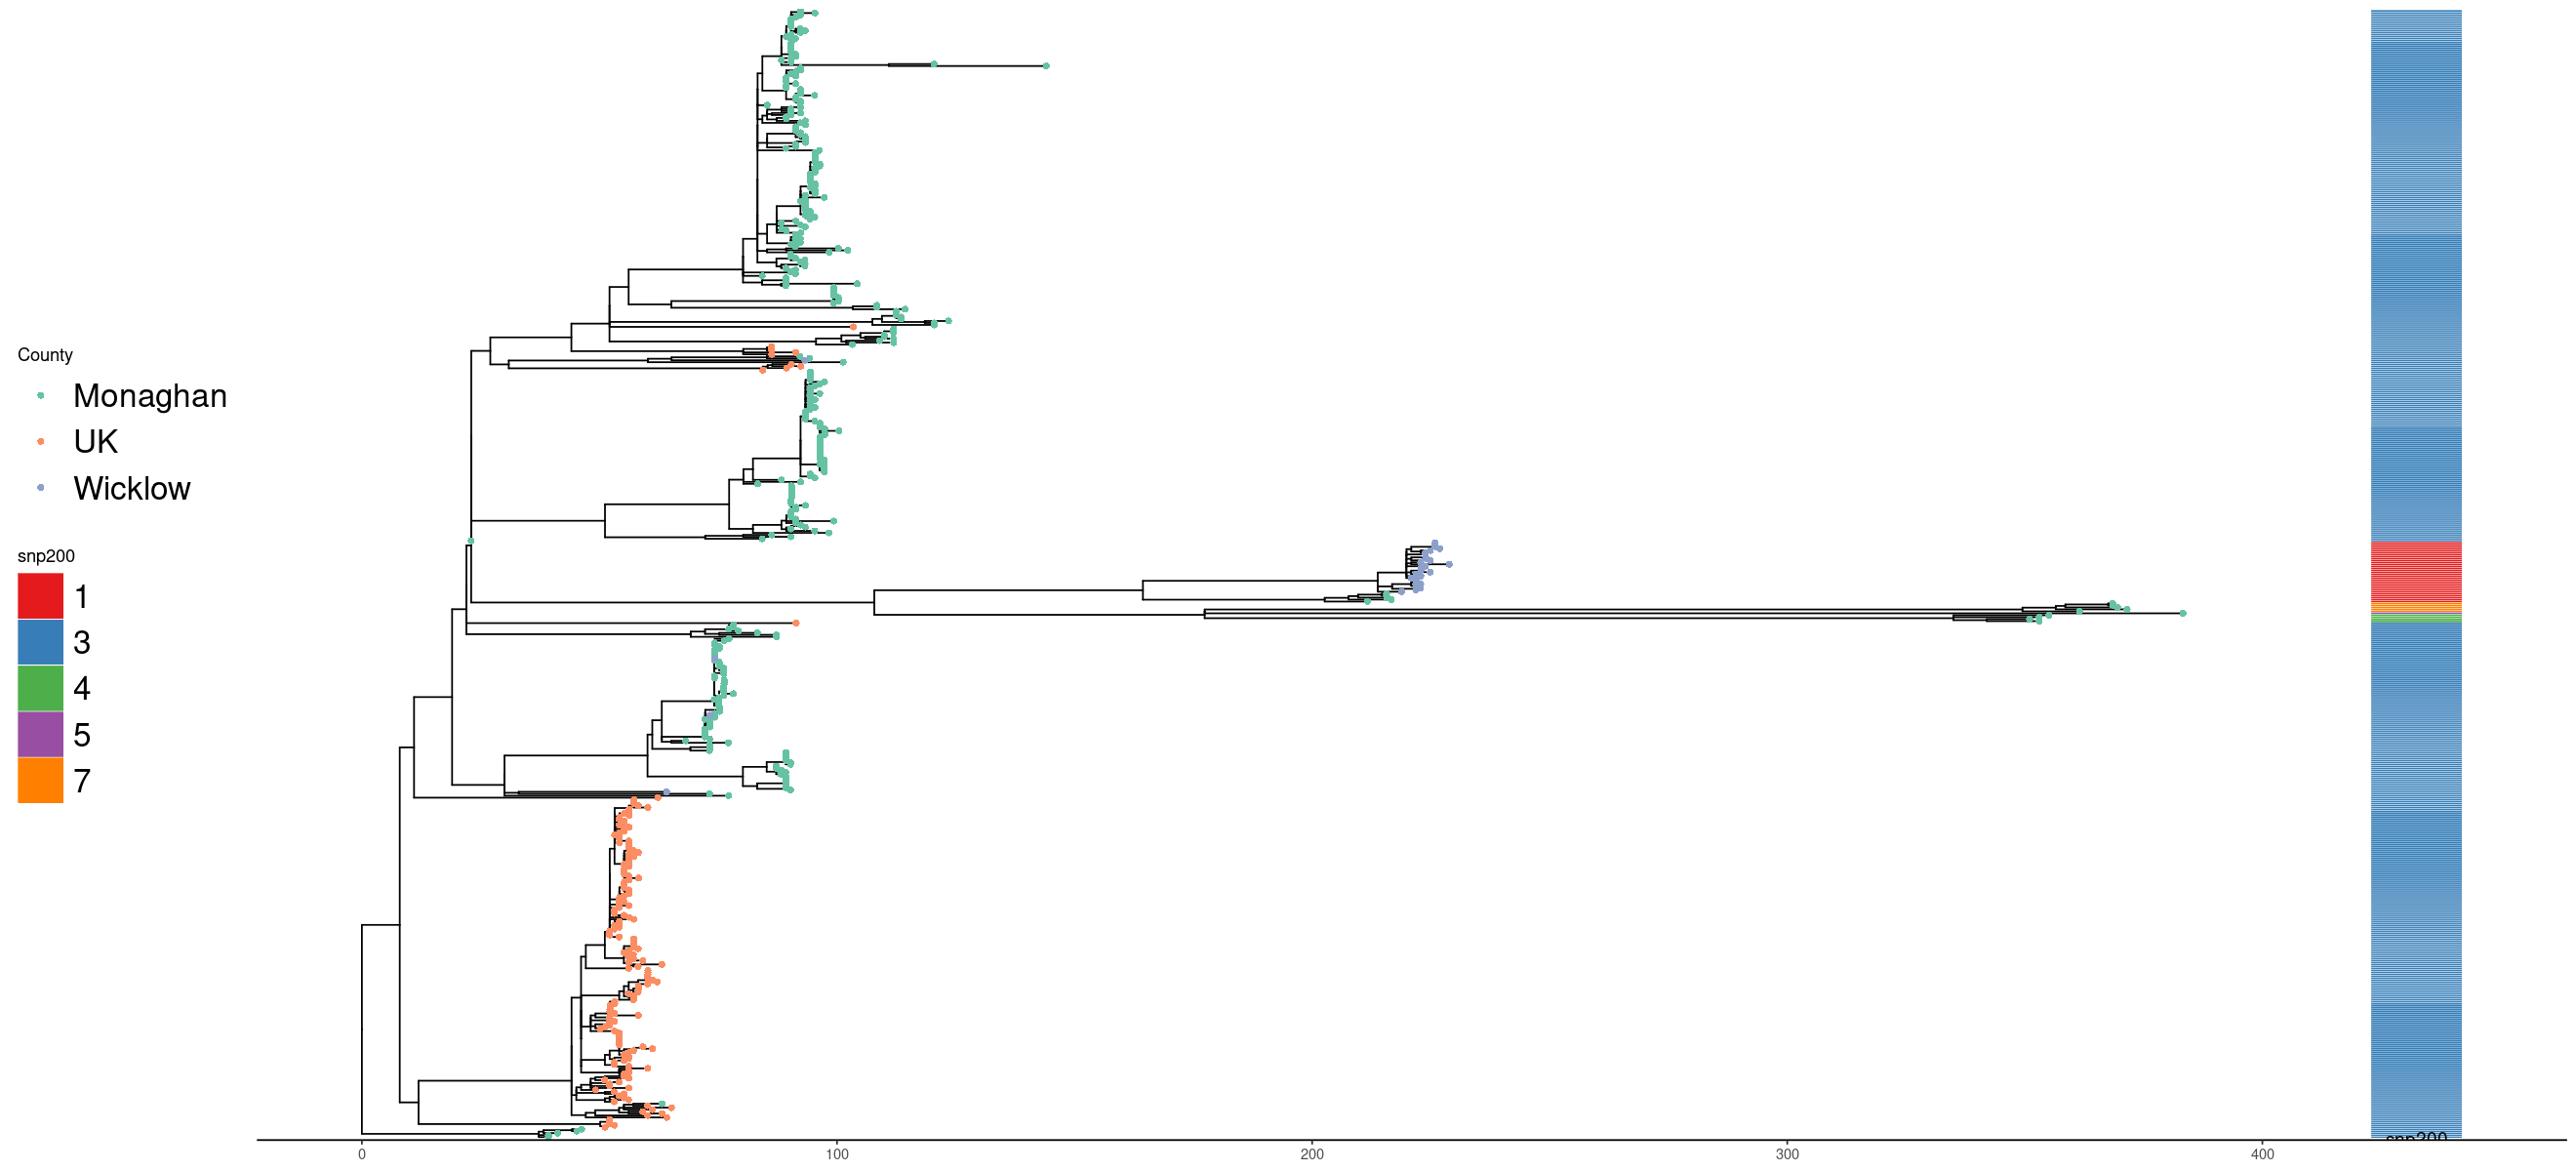

In [112]:
counties=c('Monaghan','Wicklow','UK')
tips<-row.names(iremeta[iremeta$County %in% counties,])
stree<-keep.tip(iretree,tips)

options(repr.plot.width=22, repr.plot.height=10)
ggplottree(stree,iremeta,cols=c('County','snp200'),cmaps=c('Set2','Set1'),layout='rect',tipsize=2,offset=15)

In [7]:
options(repr.plot.width=25, repr.plot.height=10)
#set.seed(1)
randtips<-sample(iretree$tip.label,80)
randtree <- keep.tip(iretree, randtips)
options(repr.plot.width=15, repr.plot.height=10)
p1<-ggplottree(randtree, iremeta, layout='rect','Country', cmap='Set2', tipsize=4)
p2<-ggplottree(randtree, iremeta, layout='rect','snp200', cmap='Set1', tipsize=4)
p1+p2

ERROR: Error in `[.data.frame`(meta[tree$tip.label, ], col): undefined columns selected


## outliers

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


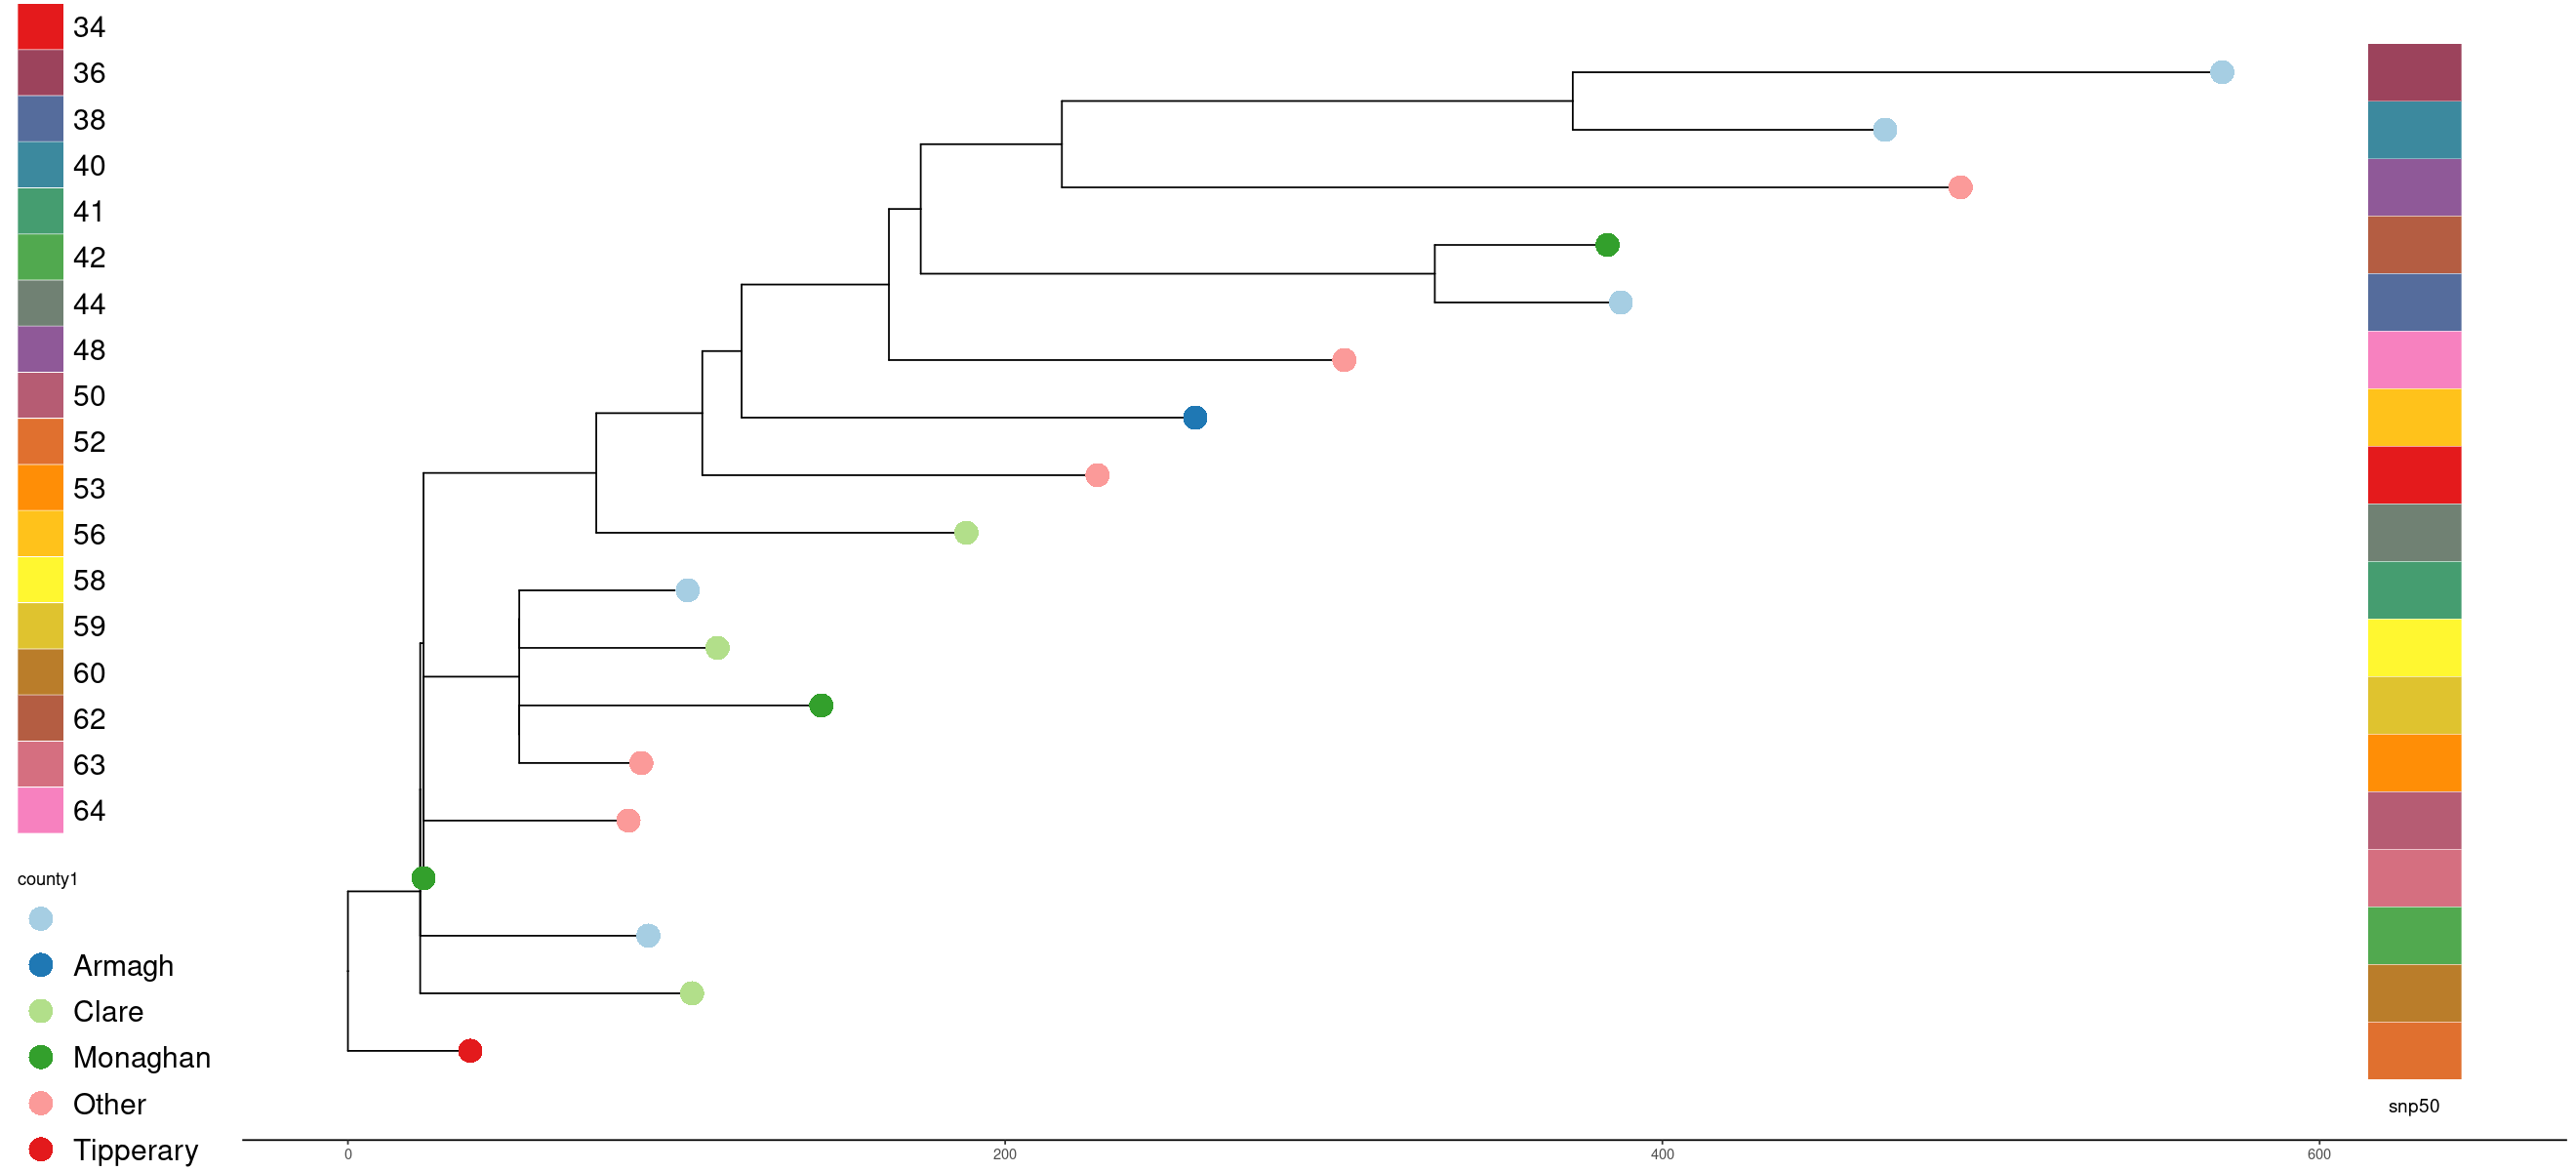

In [54]:
rare<-c('38', '41', '42', '34', '52', '64', '63', '58', '50', '60', '40', '56', '59', '48', '36', '44', '53', '62')
tips<-row.names(iremeta[iremeta$snp50 %in% rare,])
#tips <- c(tips,sample(iretree$tip.label,10))
stree<-keep.tip(iretree,tips)

options(repr.plot.width=22, repr.plot.height=10)
ggplottree(stree,iremeta,cols=c('county1','snp50'),cmaps=c('Paired','Set1'),layout='rect',tipsize=7,offset=15)

## wicklow

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


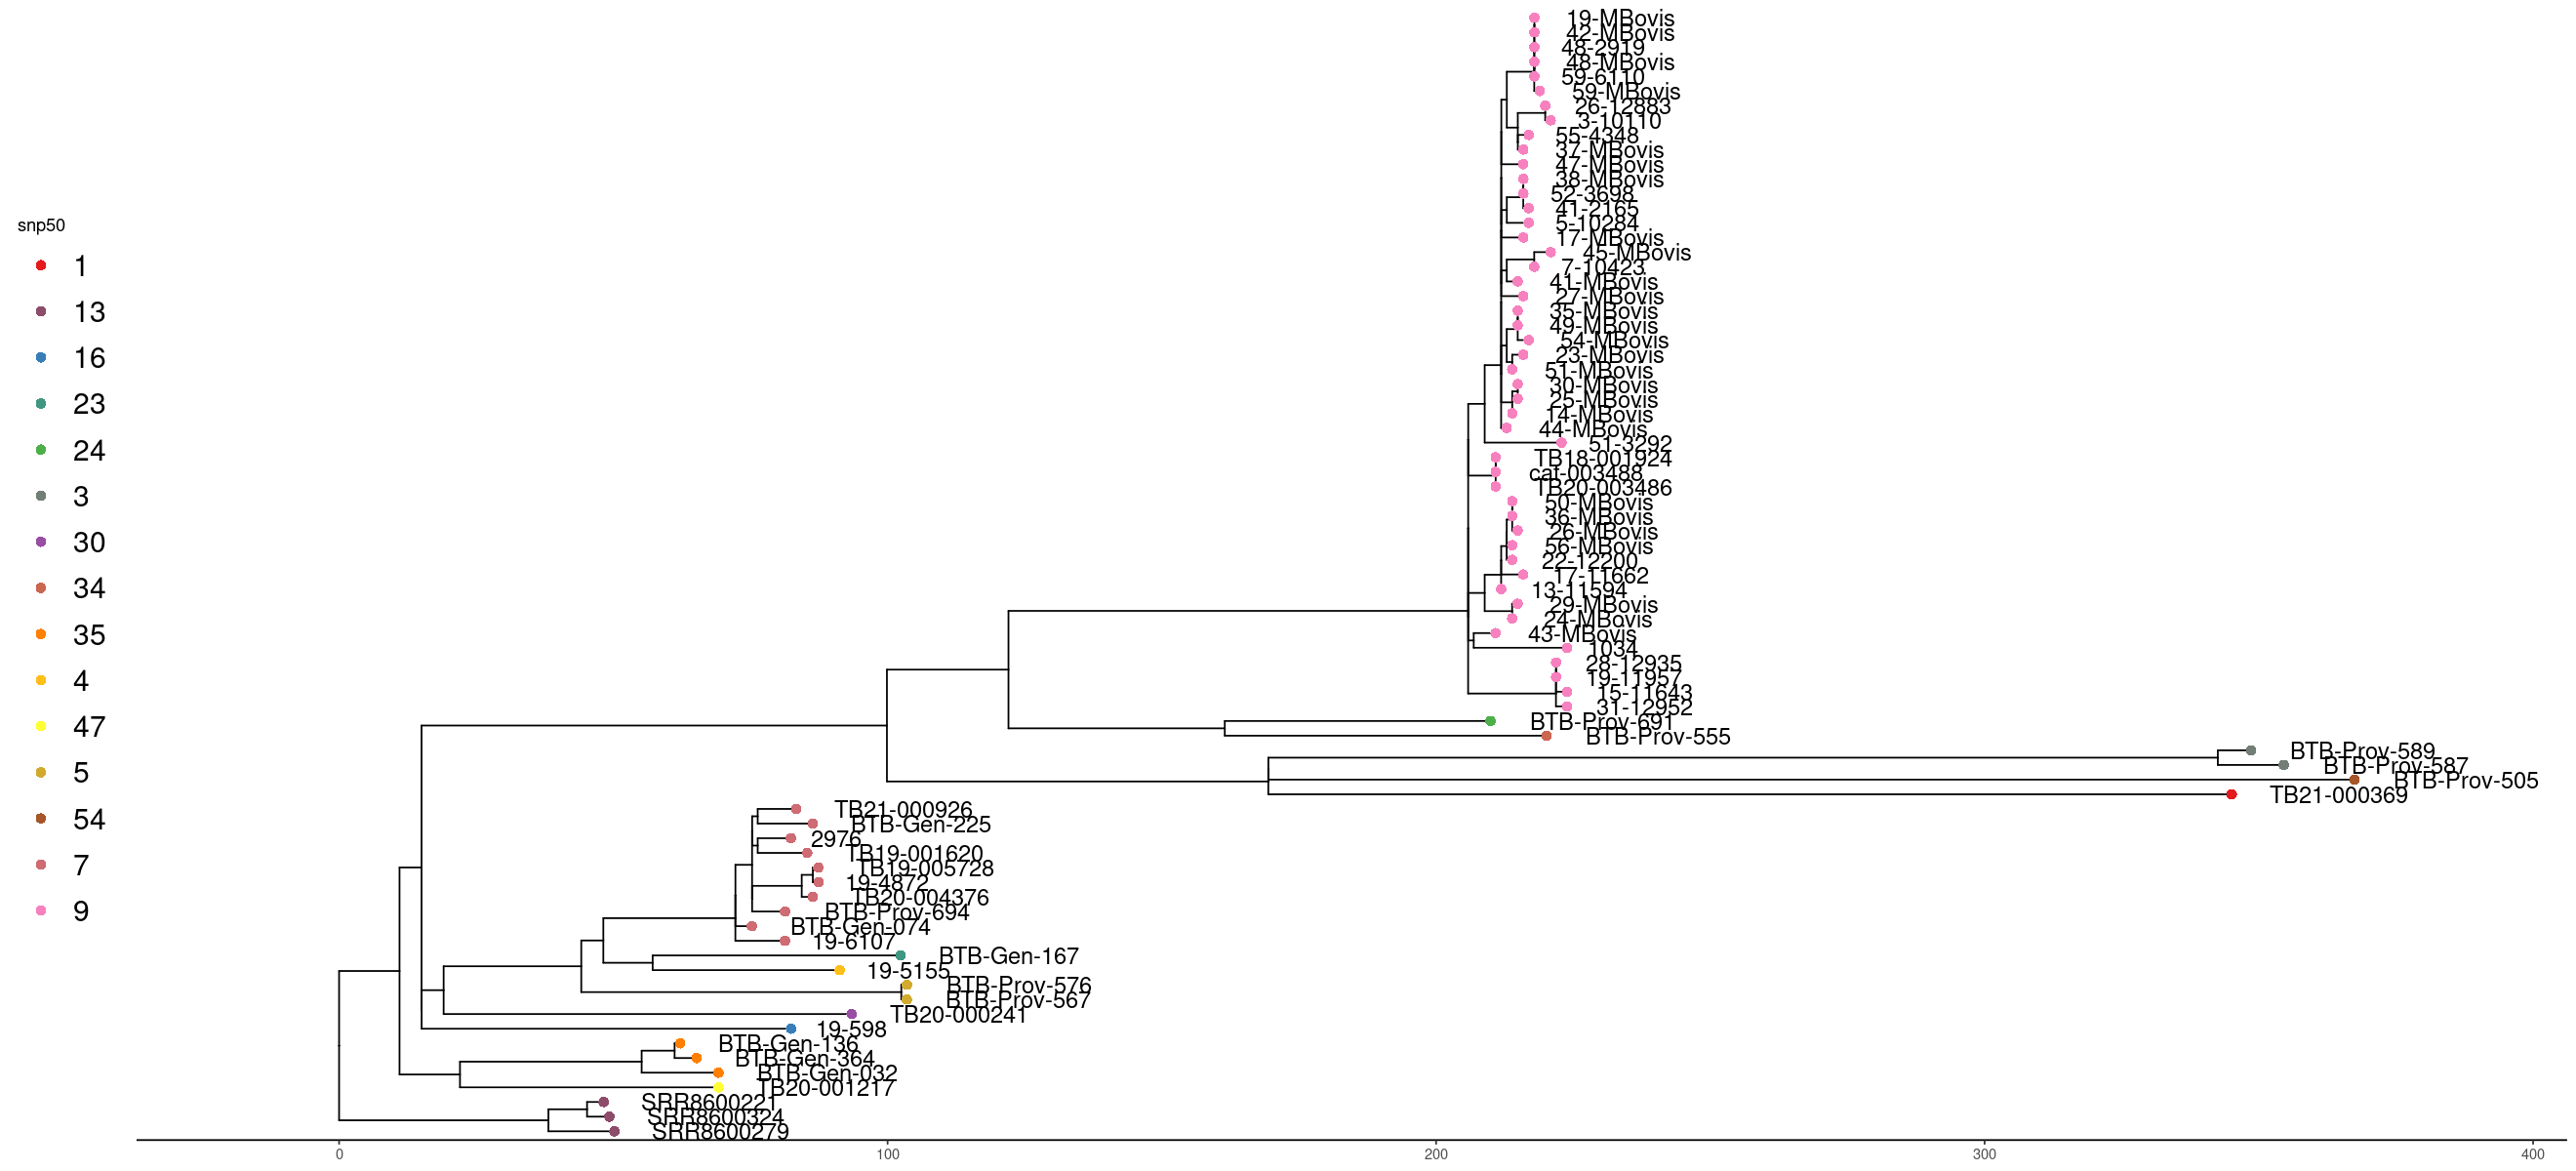

In [45]:
x<-read.table('/storage/btbgenie/wicklow_results/samples.csv',sep=',',header=TRUE,row.names=2)
randtips<-sample(iretree$tip.label,30)
tips<-x$sample
tips<- c(tips,randtips)
stree<-keep.tip(iretree,tips)
options(repr.plot.width=22, repr.plot.height=10)
ggplottree(stree,iremeta,'snp50',layout='rect',cmap='Set1',tiplabel=TRUE)